In [1]:
import csv 
import cv2
import itertools
import numpy as np
import pandas as pd 
import os 
import sys 
import tempfile
import tqdm 

from matplotlib import pyplot as plt 
from matplotlib.collections import LineCollection

import tensorflow as tf 
import tensorflow_hub as hub 
from tensorflow import keras 

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

2024-03-06 10:44:05.039671: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-06 10:44:05.243115: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-06 10:44:05.243213: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-06 10:44:05.274329: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-06 10:44:05.344312: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-06 10:44:05.345637: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
pose_sample_rpi_path = os.path.join(os.getcwd(), 'examples/lite/examples/pose_estimation/raspberry_pi')
sys.path.append(pose_sample_rpi_path)


### Functions to run pose estimation with MoveNet

In [3]:
import utils
from data import BodyPart
from ml import Movenet

movenet = Movenet('movenet_thunder')

# Apply Movenet's cropping algorithm and run inference on the input image to improve pose
# estimation accuracy.

def detect(input_tensor, inference_count = 3):
    image_height, image_width, channel = input_tensor.shape 
    # Detect pose using the full input image
    movenet.detect(input_tensor.numpy(), reset_crop_region=True)

    # Repeatedly using previous detection result to identify the region of interest and
    # croppng that region to improve detection accuracy
    for _ in range(inference_count - 1):
        person = movenet.detect(input_tensor.numpy(),reset_crop_region=False)

    return person 

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


### Function to visualize the pose estimation results


In [4]:
def draw_prediction_on_image (
        image, person, crop_region = None, close_figure = True,
        keep_input_size = False
):
    """
    image: numpy array
    person: A person entity return from the MoveNet.SinglePose model.
    close_figure: Whether to close the plt figure after function returns
    """
    # Draw the detection result on top of the image
    image_np = utils.visualize(image, [person])

    # Plot the image with detection results
    height, width, channel = image.shape 
    aspect_ratio = float(width) / height 
    fig, ax = plt.subplots(figsize = (12 * aspect_ratio, 12))
    im = ax.imshow(image_np)

    if close_figure:
        plt.close(fig)
    if not keep_input_size:
        image_np = utils.keep_aspect_ratio_resizer(image_np, (512, 512))

    return image_np

### Code to load the images, detect pose landmarks and save them into the CSV file

In [5]:
class MoveNetPreprocess(object):
    def __init__(self, 
                 images_in_folder,
                 images_out_folder,
                 csvs_out_path):
        """Create a preprocessor to detection pose"""
        self._images_in_folder = images_in_folder
        self._images_out_folder = images_out_folder 
        self._csvs_out_path = csvs_out_path 
        self._messages = []

        # Create a temp dir to store the pose CSVs per class
        self._csvs_out_folder_per_class = tempfile.mkdtemp()

        # Get list of pose classes and print image statistics
        self._pose_class_names = sorted(
            [n for n in os.listdir(self._images_in_folder) if not n.startswith('.')]
        )

    def process(self, per_pose_class_limit=None, detection_threshold = 0.1):
        """Preprocess images in the given folder."""
        # Loop through the classes and preprocess its images
        for pose_class_name in self._pose_class_names:
            print("Preprocessing", pose_class_name, file = sys.stderr)

            # Paths for the pose class
            images_in_folder = os.path.join(self._images_in_folder, pose_class_name)
            images_out_folder = os.path.join(self._images_in_folder, pose_class_name)
            csv_out_path = os.path.join(self._csvs_out_folder_per_class, pose_class_name + '.csv')

            if not os.path.exists(images_out_folder):
                os.makedirs(images_out_folder)
            
            # Detect landmarks in each image and write it to a CSV file
            with open(csv_out_path, 'w') as csv_out_file:
                csv_out_writer = csv.writer(csv_out_file, delimiter=',', quoting = csv.QUOTE_MINIMAL)

                # Get list of images
                image_names = sorted(
                    [n for n in os.listdir(images_in_folder) if not n.startswith('.')]
                )
                if per_pose_class_limit is not None:
                    image_names = image_names[:per_pose_class_limit]
                
                valid_image_count = 0

                # Detect pose landmarks from each image
                for image_name in tqdm.tqdm(image_names):
                    image_path = os.path.join(images_in_folder, image_name)

                    try: 
                        image = tf.io.read_file(image_path)
                        image = tf.io.decode_jpeg(image)
                    except:
                        self._messages.append('Skipped ' + image_path + '. Invalid image')
                        continue
                    else:
                        image = tf.io.read_file(image_path)
                        image = tf.io.decode_jpeg(image)
                        image_height, image_width, channel = image.shape
                    
                    # Skip images that isn't RGB because MoveNet require RGB images
                    if channel != 3:
                        self._messages.append('Skipped '+ image_path + '. Image isn\'t in RGB format')
                        continue
                    person = detect(image)

                    # Save landmarks if all landmarks were detected 
                    min_landmark_score = min(
                        [keypoint.score for keypoint in person.keypoints]
                    )
                    should_keep_image = min_landmark_score >= detection_threshold
                    if not should_keep_image:
                        self._messages.append('Skipped ' + image_path + 
                                              '. No pose was confidently detected.')
                        continue 
                    valid_image_count += 1

                    # Draw the prediction result on top of the image
                    output_overlay = draw_prediction_on_image(
                        image.numpy().astype(np.uint8), person,
                        close_figure=True, keep_input_size=Ture)
                    
                    # Write detection result into an iamge file
                    output_frame = cv2.cvtColor(output_overlay, cv2.COLOR_RGB2BGR)
                    cv2.imwrite(os.path.join(images_out_folder, image_name), output_frame)

                    # Get landmarks and scale it to the same size as the input iamge
                    pose_landmarks = np.array(
                        [[keypoint.coordinate.x, keypoint.coordinate.y, keypoint.score]
                         for keypoint in person.keypoints], dtype= np.float32
                    )

                    # Write the landmark coordinates to its per-class CSV
                    coordinates = pose_landmarks.flatten().astype(np.str).tolist()
                    csv_out_writer.writerow([image_name] + coordinates)

                if not valid_image_count:
                    raise RuntimeError(
                        'No valid images found for the "{}" class.'.format(pose_class_name)
                    )
        # Print the error message collected during preprocessing.
        print('\n'.join(self._messages))

        # Combines all per-class CSVs into a single output file 
        all_landmarks_df = self._all_landmarks_as_dataframe()
        all_landmarks_df.to_csv(self._csvs_out_path, index = False)

    def class_names(self):
        """List of classes found in training dataset"""
        return self._pose_class_names
    
    def _all_landmarks_as_dataframe(self):
        """Merge all per-class CSVs into a single dataframe"""
        total_df = None 
        for class_index, class_name in enumerate(self._pose_class_names):
            csv_out_path = os.path.join(self._csvs_out_folder_per_class,
                                        class_name + '.csv')
            per_class_df = pd.read_csv(csv_out_path, header=None)

            # Add the labels
            per_class_df['class_no'] = [class_index]*len(per_class_df)
            per_class_df['class_name'] = [class_name]*len(per_class_df)

            # Append the folder name to filename column
            per_class_df[per_class_df.columns[0]] = (os.path.join(class_name, '')
                + per_class_df[per_class_df.columns[0]].astype(str))
            
            if total_df is None:
                # For the first class, assign its data to the total dataframe
                total_df = per_class_df
            else:
                # Concentrate each class's data into the total dataframe
                total_df = pd.concat([total_df, per_class_df],axis = 0)
        
        list_name = [[bodypart.name + '_x', bodypart.name + '_y', 
                  bodypart.name + '_score'] for bodypart in BodyPart] 
        
        header_name = []

        for columns_name in list_name:
            header_name += columns_name 
        header_name = ['file_name'] + header_name 
        header_map = {total_df.columns[i]: header_name[i]
                      for i in range(len(header_name))}

        total_df.rename(header_map, axis = 1, inplace=True)

        return total_df


                    


        

In [6]:
is_skip_step_1 = True 

In [7]:
use_custom_dataset = False
dataset_is_split = False 

In [8]:
import os 
import random 
import shutil

def split_into_train_test(images_origin, images_dest, test_split):
    """
    Args: 
        images_origin: Path to the directory with your images.
        images_dest: Path to a directory where you want the split dataset to be
        saved.
        test_split: Fraction of data to reserve for test

    """
    _, dirs, _ = next(os.walk(images_origin))

    TRAIN_DIR = os.path.join(images_dest, 'train')
    TEST_DIR = os.path.join(images_dest, 'test')
    os.makedirs(TRAIN_DIR, exist_ok=True)
    os.makedirs(TEST_DIR, exist_ok=True)

    for dir in dirs:
        # Get all filenames for this dir
        filenames = os.listdir(os.path.join(images_origin, dir)) 
        filenames = [os.path.join(images_origin, dir, f) for f in filenames if (
            f.endswith('.png') or f.endswith('.jpg') or f.endswith('.jpeg') or f.endswith('.bmp')
        )]  
        # Shuffle the files, deterministically
        filenames.sort()
        random.seed(42)
        random.shuffle(filenames)
        # Divide them into train/test dirs
        os.makedirs(os.path.join(TRAIN_DIR, dir), exist_ok=True)
        os.makedirs(os.path.join(TEST_DIR, dir), exist_ok=True)
        test_count = int(len(filenames) *test_split)
        for i, file in enumerate(filenames):
            if i < test_count:
                destination = os.path.join(TEST_DIR, dir, os.path.split(file)[1])
            else:
                destination = os.path.join(TRAIN_DIR, dir, os.path.split(file)[1])

            shutil.copyfile(file, destination)
        print(f'Move {test_count} of {len(filenames)} from class "{dir}"  into test')
    print(f'Your split dataset is in "{images_dest}"')


### Download the preprocessed csv files 

In [9]:
# !wget images/yoga_poses/train_data.csv http://download.tensorflow.org/data/pose_classification/yoga_train_data.csv
# !wget images/yoga_poses/test_data.csv http://download.tensorflow.org/data/pose_classification/yoga_test_data.csv

csvs_out_train_path = 'images/yoga_poses/yoga_train_data.csv'
csvs_out_test_path = 'images/yoga_poses/yoga_test_data.csv'

### Load the preprocessed CSVs into TRAIN and TEST datasets

In [10]:
import pandas as pd
def load_pose_landmarks(csv_path):
    """Loads a CSV created by MoveNetPreprocessor"""
    # Load the CSV file
    dataframe = pd.read_csv("images/yoga_poses/yoga_train_data.csv")
    df_to_process = dataframe.copy()

    # Drop the file_name columns as you don't need it during training 
    df_to_process.drop(columns=['file_name'], inplace=True)

    # Extract the list of class names
    classes = df_to_process.pop('class_name').unique()

    # Extract the labels
    y = df_to_process.pop('class_no')

    # Convert the input features and labels into the correct format
    X = df_to_process.astype('float64')
    y = keras.utils.to_categorical(y)

    return X, y, classes, dataframe

Load and split the original TRAIN dataset into TRAIN (85%) and VALIDATE (the remaining 15%)

In [11]:
# Load the train data 
X, y, class_names, _ = load_pose_landmarks(csv_path=csvs_out_train_path)

# Split training data (X,y)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15)

In [12]:
# Load the test data
X_test, y_test, _, df_test = load_pose_landmarks(csvs_out_test_path)

#### Define functions to convert the pose landmarks to a pose embedding (a.k.a feature vector) for pose classification

1. Moving  the pose center to the origin
2. Scaling the pose so that the pose size become 1
3. Flattening these coordinates into a feature vector

Then use this feature vector to train a neural-network based pose classifier

In [13]:
def get_center_point(landmarks, left_bodypart, right_bodypart):
    """Calculates the center point of the two given landmarks"""
    left = tf.gather(landmarks, left_bodypart.value, axis = 1)
    right = tf.gather(landmarks, right_bodypart.value, axis = 1)
    center  = left*0.5 + right*0.5
    return center 

def get_pose_size(landmarks, torso_size_multiplier = 2.5):
    """Calculate pose size"""

    # Hips center
    hips_center = get_center_point(landmarks, BodyPart.LEFT_HIP, BodyPart.RIGHT_HIP)

    # Shoulders center
    shoulders_center = get_center_point(landmarks, BodyPart.LEFT_SHOULDER, BodyPart.RIGHT_SHOULDER)
    # Torso size as the minimum body size
    torso_size = tf.linalg.norm(shoulders_center - hips_center)
    # Pose center 
    pose_center_new = get_center_point(landmarks, BodyPart.LEFT_HIP, BodyPart.RIGHT_HIP)
    pose_center_new = tf.expand_dims(pose_center_new, axis = 1)
    # Broadcaset the pose center to the same size as the landmarks vector
    # perfor substraction
    pose_center_new = tf.broadcast_to(pose_center_new,
                                      [tf.size(landmarks) // (17*2), 17, 2])

    # Dist to pose center
    d = tf.gather(landmarks - pose_center_new, 0 , axis = 0, name = "dist_to_pose_center")

    # Max dist to pose center 
    max_dist = tf.reduce_max(tf.linalg.norm(d, axis = 0))

    # Normalize scale 
    pose_size = tf.maximum(torso_size*torso_size_multiplier, max_dist)

    return pose_size 


def normalize_pose_landmarks(landmarks):
    """Normalizes the landmarks translation by movine the pose center to (0,0) 
    and scaling it to a constant pose size"""

    # Move landmarks so that the pose center becomes (0, 0)
    pose_center = get_center_point(landmarks, BodyPart.LEFT_HIP, BodyPart.RIGHT_HIP)
    pose_center = tf.expand_dims(pose_center, axis =1)
    # Broadcast the pose center to the same size as the landmark vector perform substraction
    pose_center = tf.broadcast_to(pose_center,
                                  [tf.size(landmarks) // (17*2), 17, 2])
    landmarks = landmarks - pose_center 

    # Scale the landmarks to a constant pose size
    pose_size = get_pose_size(landmarks)
    landmarks /= pose_size 

    return landmarks


def landmarks_to_embedding(landmarks_and_scores):
    """Converts the input landmarks into a pose embedding"""
    # Reshape the flat input into a matrix with shape = (17, 3)
    reshaped_inputs = keras.layers.Reshape((17, 3))(landmarks_and_scores)

    # Normalize landmarks 2D
    landmarks = normalize_pose_landmarks(reshaped_inputs[:, :, :2])

    # Flatten the normalized landmark coordinates into a vector
    embedding = keras.layers.Flatten()(landmarks)

    return embedding
  



### Define a Keras model for pose classification

Our Keras model takes the detected pose landmarks, then calculates the pose embedding and predicts the pose class.

In [14]:
# Define the model
inputs = tf.keras.Input(shape=(51))
embedding = landmarks_to_embedding(inputs)

layer = keras.layers.Dense(128, activation = tf.nn.relu6)(embedding)
layer = keras.layers.Dropout(0.5)(layer)
layer = keras.layers.Dense(64, activation = tf.nn.relu6)(layer)
layer = keras.layers.Dropout(0.5)(layer)
outputs = keras.layers.Dense(len(class_names), activation = 'softmax')(layer)

model = keras.Model(inputs, outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 51)]                 0         []                            
                                                                                                  
 reshape (Reshape)           (None, 17, 3)                0         ['input_1[0][0]']             
                                                                                                  
 tf.__operators__.getitem (  (None, 17, 2)                0         ['reshape[0][0]']             
 SlicingOpLambda)                                                                                 
                                                                                                  
 tf.compat.v1.gather (TFOpL  (None, 2)                    0         ['tf.__operators__.getitem

2024-03-06 10:44:08.512928: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-06 10:44:08.514718: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


 mbda)                                                              ]                             
                                                                                                  
 tf.__operators__.add (TFOp  (None, 2)                    0         ['tf.math.multiply[0][0]',    
 Lambda)                                                             'tf.math.multiply_1[0][0]']  
                                                                                                  
 tf.compat.v1.size (TFOpLam  ()                           0         ['tf.__operators__.getitem[0][
 bda)                                                               0]']                          
                                                                                                  
 tf.expand_dims (TFOpLambda  (None, 1, 2)                 0         ['tf.__operators__.add[0][0]']
 )                                                                                                
          

In [16]:
model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

# Add a checkpoint callback to store the checkpoint that has the highest validation accuracy
checkpoint_path = 'pose_classification_models/weights.best.hdf5'
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path, monitor = 'val_accuracy',
                                             verbose = 1,
                                             save_best_only = True,
                                             mode = 'max')

earlystopping = keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                              patience = 10)

# Start training
history = model.fit(X_train, y_train,
                    epochs = 100,
                    batch_size = 16,
                    validation_data = (X_val, y_val),
                    callbacks = [checkpoint, earlystopping])

Epoch 1/100
49/52 [===========================>..] - ETA: 0s - loss: 1.4957 - accuracy: 0.4439 
Epoch 1: val_accuracy improved from -inf to 0.54795, saving model to pose_classification_models/weights.best.hdf5
52/52 [==============================] - 1s 6ms/step - loss: 1.4880 - accuracy: 0.4416 - val_loss: 1.3322 - val_accuracy: 0.5479
Epoch 2/100
 1/52 [..............................] - ETA: 0s - loss: 1.5019 - accuracy: 0.2500
Epoch 2: val_accuracy improved from 0.54795 to 0.66438, saving model to pose_classification_models/weights.best.hdf5
52/52 [==============================] - 0s 2ms/step - loss: 1.1773 - accuracy: 0.5328 - val_loss: 0.9971 - val_accuracy: 0.6644
Epoch 3/100
52/52 [==============================] - ETA: 0s - loss: 0.9198 - accuracy: 0.6496
Epoch 3: val_accuracy improved from 0.66438 to 0.71233, saving model to pose_classification_models/weights.best.hdf5


/home/lengocthanh/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


52/52 [==============================] - 0s 2ms/step - loss: 0.9198 - accuracy: 0.6496 - val_loss: 0.7642 - val_accuracy: 0.7123
Epoch 4/100
37/52 [====================>.........] - ETA: 0s - loss: 0.7949 - accuracy: 0.6824
Epoch 4: val_accuracy improved from 0.71233 to 0.81507, saving model to pose_classification_models/weights.best.hdf5
52/52 [==============================] - 0s 2ms/step - loss: 0.7872 - accuracy: 0.6910 - val_loss: 0.6417 - val_accuracy: 0.8151
Epoch 5/100
52/52 [==============================] - ETA: 0s - loss: 0.6783 - accuracy: 0.7348
Epoch 5: val_accuracy improved from 0.81507 to 0.86301, saving model to pose_classification_models/weights.best.hdf5
52/52 [==============================] - 0s 2ms/step - loss: 0.6783 - accuracy: 0.7348 - val_loss: 0.5440 - val_accuracy: 0.8630
Epoch 6/100
 1/52 [..............................] - ETA: 0s - loss: 0.5521 - accuracy: 0.7500
Epoch 6: val_accuracy improved from 0.86301 to 0.89726, saving model to pose_classification_mo

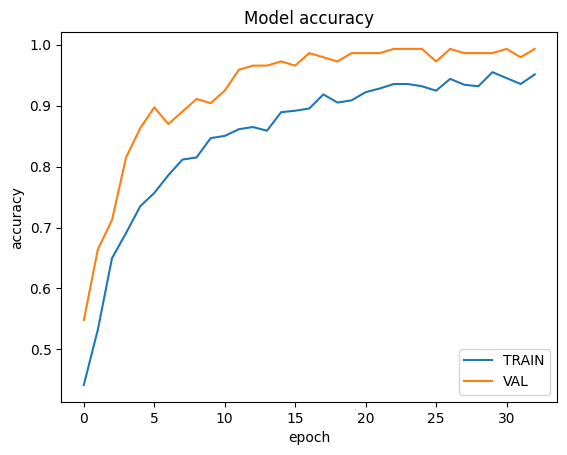

In [17]:
# Visualize the training history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'VAL'], loc = 'lower right')
plt.show()

In [18]:
# Evaluate the model using the TEST dataset
loss, accuracy = model.evaluate(X_test, y_test)

31/31 [==============================] - 0s 962us/step - loss: 0.1176 - accuracy: 0.9711


### Draw the confusion matrix to better understand the model performance

31/31 [==============================] - 0s 792us/step
Confusion matrix, without normalization

Classification Report:
               precision    recall  f1-score   support

       chair       0.92      1.00      0.96       200
       cobra       0.98      0.98      0.98       191
         dog       0.99      0.99      0.99       183
        tree       1.00      0.92      0.96       200
     warrior       0.98      0.96      0.97       194

    accuracy                           0.97       968
   macro avg       0.97      0.97      0.97       968
weighted avg       0.97      0.97      0.97       968



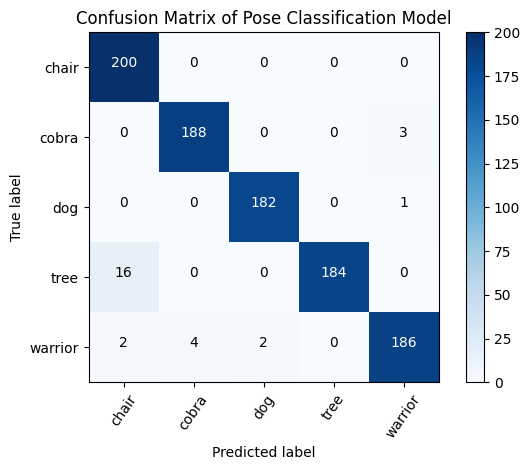

In [19]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """Plots the confusion matrix."""
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print('Confusion matrix, without normalization')

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=55)
  plt.yticks(tick_marks, classes)
  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
              horizontalalignment="center",
              color="white" if cm[i, j] > thresh else "black")

  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.tight_layout()

# Classify pose in the TEST dataset using the trained model
y_pred = model.predict(X_test)

# Convert the prediction result to class name
y_pred_label = [class_names[i] for i in np.argmax(y_pred, axis=1)]
y_true_label = [class_names[i] for i in np.argmax(y_test, axis=1)]

# Plot the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
plot_confusion_matrix(cm,
                      class_names,
                      title ='Confusion Matrix of Pose Classification Model')

# Print the classification report
print('\nClassification Report:\n', classification_report(y_true_label,
                                                          y_pred_label))

### Convert the pose classification model to Tensorflow Lite

In [21]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

print('Model size: %dKB' % (len(tflite_model)/1024))

with open('pose_classification_models/pose_classifier.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpse8p16wu/assets


INFO:tensorflow:Assets written to: /tmp/tmpse8p16wu/assets


Model size: 26KB


2024-03-06 11:07:32.926756: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-03-06 11:07:32.926780: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-03-06 11:07:32.927098: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpse8p16wu
2024-03-06 11:07:32.928501: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-03-06 11:07:32.928512: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpse8p16wu
2024-03-06 11:07:32.931658: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-03-06 11:07:32.932506: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-03-06 11:07:32.963819: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpse8p16wu
2024-03

In [23]:
# Write the label file which contains mapping from the class indexes to the human readable class name
with open('pose_labels.txt', 'w') as f:
    f.write('\n'.join(class_names))